In [30]:
import torch as tch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from toolbox import disp, disp_loss


In [31]:
# device = 'cpu'
# device = 'cuda'
# batch_size=
device = tch.device("cuda" if tch.cuda.is_available() else "cpu")

In [32]:
# input will be array in range[-1,1] 
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])
# should I augment the data?


train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
# Restricting to only ones.
# label_mask = train_dataset.targets == 1
# train_dataset.data = train_dataset.data[label_mask]
# train_dataset.targets = train_dataset.targets[label_mask]

subset_size = 512  # Choose the desired subset size max size is 50000
train_subset = tch.utils.data.Subset(train_dataset, range(subset_size))
test_subset = tch.utils.data.Subset(test_dataset, range(subset_size))


batch_size = 32
train_loader = tch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = tch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [33]:

T = 500
beta_1 = 10**-4
beta_T = 10**-2
beta_1_tensor = tch.tensor(beta_1).to(device)
height = 28
width = 28
# list containing \bar{alpha_t}
betas = tch.linspace(beta_1, beta_T, T, device=device)  # Linear schedule
alphas = 1 - betas
alphas_cumprod = tch.cumprod(alphas, dim=0)  # Cumulative product of alphas
diffusion_scheduler = alphas_cumprod
print("a")


a


In [34]:
# #architecture from https://github.com/TeaPearce/Conditional_Diffusion_MNIST
# class ResidualConvBlock(nn.Module):
#     def __init__(
#         self, in_channels: int, out_channels: int, is_res: bool = False
#     ) -> None:
#         super().__init__()
#         '''
#         standard ResNet style convolutional block
#         '''
#         self.same_channels = in_channels==out_channels
#         # do we add skip connections?
#         self.is_res = is_res
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, 3, 1, 1),
#             nn.BatchNorm2d(out_channels),
#             nn.GELU(),
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(out_channels, out_channels, 3, 1, 1),
#             nn.BatchNorm2d(out_channels),
#             nn.GELU(),
#         )

#     def forward(self, x: tch.Tensor) -> tch.Tensor:
#         if self.is_res:
#             x1 = self.conv1(x)
#             x2 = self.conv2(x1)
#             # what's this
#             # this adds on correct residual in case channels have increased
#             if self.same_channels:
#                 out = x + x2
#             else:
#                 out = x1 + x2 
#             #why divide by 1.414
#             return out / 1.414
#         else:
#             x1 = self.conv1(x)
#             x2 = self.conv2(x1)
#             return x2

# class UnetDown(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(UnetDown, self).__init__()
#         '''
#         process and downscale the image feature maps
#         '''
#         # ResNet Block and MaxPool (reduce number of pixels by 4)
#         layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
#         self.model = nn.Sequential(*layers)

#     def forward(self, x):
#         return self.model(x)

# class UnetUp(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(UnetUp, self).__init__()
#         '''
#         process and upscale the image feature maps
#         '''
#         # why the channels twice?
#         layers = [
#             nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
#             ResidualConvBlock(out_channels, out_channels),
#             ResidualConvBlock(out_channels, out_channels),
#         ]
#         self.model = nn.Sequential(*layers)
#     # TODO Explain this
#     def forward(self, x, skip):
#         x = tch.cat((x, skip), 1)
#         x = self.model(x)
#         return x
# # Embedding time or direction. 
# # Not positional embedding, 
# class EmbedFC(nn.Module):
#     def __init__(self, input_dim, emb_dim):
#         super(EmbedFC, self).__init__()
#         '''
#         generic one layer FC NN for embedding things  
#         '''
#         self.input_dim = input_dim
#         layers = [
#             nn.Linear(input_dim, emb_dim),
#             nn.GELU(),
#             nn.Linear(emb_dim, emb_dim),
#         ]
#         self.model = nn.Sequential(*layers)

# # TODO Explain
#     def forward(self, x):
#         x = x.view(-1, self.input_dim)
#         return self.model(x)
    


# class ContextUnet(nn.Module):
#     def __init__(self, in_channels, n_feat = 256, n_classes=10):
#         super(ContextUnet, self).__init__()

#         self.in_channels = in_channels
#         self.n_feat = n_feat
#         self.n_classes = n_classes

#         self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

#         self.down1 = UnetDown(n_feat, n_feat)
#         self.down2 = UnetDown(n_feat, 2 * n_feat)

#         self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())
#         # why twe embeddings?
#         self.timeembed1 = EmbedFC(1, 2*n_feat)
#         self.timeembed2 = EmbedFC(1, 1*n_feat)
#         self.contextembed1 = EmbedFC(n_classes, 2*n_feat)
#         self.contextembed2 = EmbedFC(n_classes, 1*n_feat)
        

#         # TODO Explain up0
#         self.up0 = nn.Sequential(
#             # nn.ConvTranspose2d(6 * n_feat, 2 * n_feat, 7, 7), # when concat temb and cemb end up w 6*n_feat
#             nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7), # otherwise just have 2*n_feat
#             nn.GroupNorm(8, 2 * n_feat),
#             nn.ReLU(),
#         )

#         self.up1 = UnetUp(4 * n_feat, n_feat)
#         self.up2 = UnetUp(2 * n_feat, n_feat)
#         self.out = nn.Sequential(
#             nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
#             nn.GroupNorm(8, n_feat),
#             nn.ReLU(),
#             nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
#         )

#     def forward(self, x, c, t, context_mask):
#         # x is (noisy) image, c is context label, t is timestep, 
#         # context_mask says which samples to block the context on

#         x = self.init_conv(x)
#         down1 = self.down1(x)
#         down2 = self.down2(down1)
#         hiddenvec = self.to_vec(down2)

#         # convert context to one hot embedding
#         c = nn.functional.one_hot(c, num_classes=self.n_classes).type(tch.float)
        
#         # mask out context if context_mask == 1
#         context_mask = context_mask[:, None]
#         context_mask = context_mask.repeat(1,self.n_classes)
#         context_mask = (-1*(1-context_mask)) # need to flip 0 <-> 1
#         c = c * context_mask
        
#         # embed context, time step
#         cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
#         temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
#         cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
#         temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

#         # could concatenate the context embedding here instead of adaGN
#         # hiddenvec = torch.cat((hiddenvec, temb1, cemb1), 1)

#         up1 = self.up0(hiddenvec)
#         # up2 = self.up1(up1, down2) # if want to avoid add and multiply embeddings
#         up2 = self.up1(cemb1*up1+ temb1, down2)  # add and multiply embeddings
#         up3 = self.up2(cemb2*up2+ temb2, down1)
#         out = self.out(tch.cat((up3, x), 1))
#         return out



In [35]:
# #architecture from https://github.com/TeaPearce/Conditional_Diffusion_MNIST

class ResConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, skip_connection = False):
        super().__init__()
        self.same_channels = (in_channels==out_channels)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.skip_connection = skip_connection

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size=3, stride=1, padding=1),
            # expects input of size (N,out_channels, H, W)
            nn.BatchNorm2d(out_channels),
            # Gaussian Linear Unit
            nn.GELU(),
            # Maybe use SiLu from the paper
            # nn.SiLU()
        )
# Why two convolutional layers?
# I'll try also without second layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size=3, stride=1, padding=1),
            # expects input of size (N,out_channels, H, W)
            nn.BatchNorm2d(out_channels),
            # Gaussian Linear Unit
            nn.GELU(),
            # Maybe use SiLu from the paper
            # nn.SiLU()
    )
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        if self.skip_connection:
            if self.same_channels:
                out = x+x2
            else:
                out = x1+x2
                # divide by sqrt(2) to normalize variance
                # it's just easier to divide by 1.414 ~ sqrt(2)s
            return out/1.414
        else:
            return x2
        
    # # Case for ResBLOCK having only 1 convolution
    # def forward(self, x):
    #     x1 = self.conv1(x)
    #     return x1
        
# downsampling layer
# reduces size of image by 2 in each dimension
class UnetDown(nn.Module):
    def __init__(self, in_channels,out_channels):
        super().__init__()
        self.model = nn.Sequential(
            ResConvBlock(in_channels,out_channels),
            nn.MaxPool2d(kernel_size=2),
        )
    def forward(self, x):
        return self.model(x)
    
# Upsample the image.
# Why Res block twice though?
class UnetUp(nn.Module):
    def __init__(self,in_channels, out_channels):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            ResConvBlock(out_channels, out_channels),
            ResConvBlock(out_channels, out_channels)
        )
    def forward(self,x, skip):
        # add a skip connection as a separate channel.
        # This doubles the number of channels, so UnetUp will double the number of channels
        x = tch.cat((x,skip), dim=1)
        return self.model(x)

## layer for embedding time or context
#  nothing complicated like positional embedding
class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super().__init__()
        self.input_dim = input_dim
        self.model = nn.Sequential(
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        )
# input_dim is either n_classes(context) or 1(time)
    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)
    


class ContextUnet(nn.Module):
    # the main architecture. 
    def __init__(self,in_channels, num_features, num_classes):
        super().__init__()


 
        self.in_channels = in_channels
        self.num_features = num_features
        self.num_classes = num_classes

        # num_groups for the sole GroupNorm Layer
        # Was 8 in original repo
        # So number of channels must be a multiple of 8
        num_groups = 8
        self.init = ResConvBlock(in_channels, num_features, skip_connection=True)
        self.down1 = UnetDown(num_features,num_features)
        self.down2 = UnetDown(num_features, 2*num_features)
        # This takes 7x7 image and makes it into a vector (1x1) image
        self.to_vec = nn.Sequential(
            nn.AvgPool2d(kernel_size=7),
            nn.GELU(),
        )
        # 
        self.up0 = nn.Sequential(
        # take 1x1 image and upscale to 7x7
        nn.ConvTranspose2d(2 * num_features, 2 * num_features, kernel_size=7, stride=7), # otherwise just have 2*num_features
        nn.GroupNorm(num_groups, 2 * num_features),
        # originally was RELu
        nn.GELU(),
        )
        # This will add the embedding to input of up1 layer
        self.embedtime1 = EmbedFC(1, 2*num_features)
        self.embedcontext1 = EmbedFC(num_classes, 2*num_features)
        # Because of skip connection we have to double number of features
        self.up1 = UnetUp(4*num_features, num_features)

        self.embedtime2 = EmbedFC(1, num_features)
        self.embedcontext2 = EmbedFC(num_classes, num_features)
        # Again skip connections
        self.up2 = UnetUp(2*num_features, num_features)
        
        # skip connections again
        self.out = nn.Sequential(
            nn.Conv2d(2 * num_features, num_features, kernel_size=3, stride=1,padding=1),
            nn.GroupNorm(num_groups, num_features),
            nn.GELU(),
            nn.Conv2d(num_features, self.in_channels, kernel_size=3, stride=1, padding=1),
        )
    def forward(self, x, t, c):
        x = self.init(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        vector = self.to_vec(down2)
        up0 = self.up0(vector)
        # embeddings
        # c = nn.functional.one_hot(c, num_classes=self.num_classes).type(tch.float)
        c = nn.functional.one_hot(c.type(tch.int64), num_classes=self.num_classes).type(tch.float) 

        time1 = self.embedtime1(t).view(-1,2*self.num_features,1,1)
        context1 = self.embedcontext1(c).view(-1,2*self.num_features,1,1)
        # first skip connection
        # first use of context and time as in the repo
        # I don't use context guidance
        up1 = self.up1(up0*context1+time1, down2)

        #another embedding
        time2 = self.embedtime2(t).view(-1,self.num_features,1,1)
        context2 = self.embedcontext2(c).view(-1,self.num_features,1,1)   
        up2 = self.up2(up1*context2+time2, down1)      

        # another skip connection along channels   
        out = self.out(tch.cat((up2,x), dim=1))
        return out

In [36]:
# a = tch.randn(1,1,28,28)
# t = tch.Tensor([1])
# digit = tch.tensor([0])
# print(a.shape)
# model = ContextUnet(in_channels=1, num_features=64, num_classes=10)
# model(a,t,digit)


In [37]:
num_features = 128
num_classes = 10
class diffusionModel(nn.Module):
    def __init__(self,model = ContextUnet(1, num_features=num_features,num_classes=10)
                 ,T=500, beta_1 = 10**-4, beta_T = 10**-2):
        super().__init__()
        self.model = model
        self.T = T

        betas = tch.linspace(beta_1, beta_T, T, device=device)  # Linear schedule from DDPM paper
        alphas = 1 - betas
        alphas_cumprod = tch.cumprod(alphas, dim=0)  # Cumulative product of alphas
        diffusion_scheduler = alphas_cumprod
        self.alphas = alphas
        self.betas = betas
        self.diffusion_scheduler= diffusion_scheduler
        self.one_over_sqrt_alpha = 1/tch.sqrt(alphas)
        self.one_minus_over_sqrt_alpha_bar = 1/tch.sqrt(1-diffusion_scheduler)
        self.sqrt_beta = tch.sqrt(betas)
    # for training the network. Just pass arguments through the network
    def forward(self, x, t:tch.Tensor, c:tch.Tensor):
        return self.model(x,t,c)
    # for generating images
    def generate_image(self, digit:int):
        self.eval()
        with tch.no_grad():
            c = tch.tensor([digit]).to(device)
            # generate x_T ~ N(0,1)
            x_i = tch.randn(1,1,28,28).to(device)
            for i in range(self.T, 0, -1):
                t_current = tch.tensor([i/self.T]).to(device)
                z = tch.randn(1,1,height,width) if i>1 else 0
                eps = self(x_i,t_current,c)
                x_i = (self.one_over_sqrt_alpha[i]*
                       (x_i-
              (1-self.alphas[i])/self.one_minus_over_sqrt_alpha_bar[i]*eps   )
                   +self.sqrt_beta[i]*z
                )

        return x_i.detach().cpu().numpy()
                

In [38]:
diffModel = diffusionModel()


# Instantiate the model
# optimizer and scheduler
optimizer = tch.optim.AdamW(diffModel.parameters(), lr=1e-4,
                            weight_decay=1e-5)
# scheduler = tch.optim.lr_scheduler.StepLR(optim = diffusionModel()izer, step_size=10000,
                                        #   gamma=0.2)
loss_func = tch.nn.MSELoss(reduction='mean')


total_params = sum(p.numel() for p in diffModel.parameters())

print(f"modifiedUnet has {total_params:,} parameters.")


modifiedUnet has 6,585,601 parameters.


In [39]:
import time

def estimate_remaining_time(start_time, current_epoch, total_epochs):
    """Estimates the remaining training time.

    Args:
        start_time: The start time of the training process.
        current_epoch: The current epoch number.
        total_epochs: The total number of epochs.

    Returns:
        None
    """
    elapsed_time = time.time() - start_time
    time_per_epoch = elapsed_time / (current_epoch + 1)
    remaining_time = time_per_epoch * (total_epochs - current_epoch - 1)
    remaining_hours = int(remaining_time // 3600)
    remaining_minutes = int((remaining_time % 3600) // 60)
    remaining_seconds = int(remaining_time % 60)
    print(f"Estimated remaining time: {remaining_hours:02d}:{remaining_minutes:02d}:{remaining_seconds:02d}")

In [ ]:
#training
running_loss = 0.0
epoch_loss_ = 0.0
epoch_loss = 0.0
n_epoch = 50

 
for epoch in range(n_epoch):
    i = 0
    for data in train_loader:
        ###### COMPLETER ICI ######
        start_time = time.time()
        loss_val = 0 
        images,labels = data
        images, labels = images.to(device), labels.to(device)
        timesteps = tch.randint(1, diffModel.T, size=(images.shape[0],), device=device)  # Move timesteps to the device
        # generating a batch of random noise
        
        noise = tch.randn_like(images).to(device)
        alpha_bar = diffusion_scheduler[timesteps].view(-1,1,1,1).to(device)
        noised_image = (tch.sqrt(alpha_bar)*images
                        +tch.sqrt(1-alpha_bar)*noise)
        # Divide timestep by overall time
        # predicted_noise = diffModel(noised_image,labels, timesteps/diffModel.T)
        predicted_noise = diffModel(noised_image,labels, timesteps.type(tch.float32)/diffModel.T)

        loss_val = loss_func(noise, predicted_noise)
        ## Gradient calculation
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        #####

        running_loss += loss_val.item()
        epoch_loss += loss_val.item()
    print(f"epoch= {epoch}", end="\r", flush=True)
    if epoch % 10 == 0:    # every 100 epoch...
        disp_loss(epoch_loss, epoch)
        estimate_remaining_time(start_time, epoch, n_epoch)

    i = i+1
    epoch_loss = 0.0
    # scheduler.step()  
print("Finished training")
#save the model weights after training
tch.save(diffModel.state_dict(), 'model_weights.pth')


RuntimeError: mat1 and mat2 must have the same dtype, but got Long and Float

In [ ]:
# # loading model from weights
# state_dict = tch.load("model_weights.pth")

# # Load the state dictionary into the model
# modifiedUnet.load_state_dict(state_dict)

# modifiedUnet = modifiedUnet.to(device)

# # Set the model to evaluation mode
# modifiedUnet.eval()

In [129]:
def normalize_data(images):
    # for each image take a maximu of absolute values. Look at channels, height and width
    # thus each image gets scaled individually
    max_vals = tch.amax(tch.abs(images), dim=(1, 2, 3), keepdim=True)
    # images are between [-1,1]
    images = images/max_vals
    return images
# how to generate image from noise
# algorith from DDPM paper
def generate_image(n_images, labels, noise_predictor, device=device):
    labels = tch.tensor(labels).to(device)
    images = tch.randn(n_images, 1, height, width).to(device)
    images = normalize_data(images)
    i = T - 1  
    while i >= 0:  
        times = tch.tensor([i] * n_images).to(device)
        alpha_bar = diffusion_scheduler[i].to(device)
        if i > 0:  
            noise = tch.randn(n_images, 1, height, width).to(device)
        else:
            noise = images * 0
        images = (1 / tch.sqrt(alphas[i])) * (images - (1 - alphas[i]) / tch.sqrt(1 - diffusion_scheduler[i]) * noise_predictor(images, labels, times)) + tch.sqrt(betas[i]) * noise
        images = normalize_data(images)
        i = i - 1  # Decrement i for the next iteration
    return images.detach().cpu().numpy()

(<Figure size 850.394x141.732 with 6 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

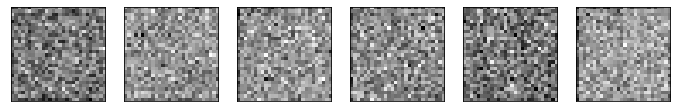

In [130]:
images = generate_image(n_images=6, labels=[1,2,3,4,5,6], noise_predictor=modifiedUnet).squeeze(1)
disp(images, shape = (1,6), scale=1)